# Library loading

In [1]:
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility
import time, h5py, neuravi, torch

from sklearn.metrics import mean_squared_error

from tqdm import tqdm 

# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = get_default_device()
print(device)

CUDA AVAILABLE?  True
cuda


# Loading data

In [2]:
# custom data loader, automatically sent to device
ds = neuravi.data_loader("./data/DataSet_0p20val.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5",
                         device)

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# Training 1 model 

Architecture: 4 layers, 300 neurons per layer, dropout 0.1

With such high dropout, we may want to increase the patience quite significantly.

In [8]:
nb_layers = 10
nb_neurons = 500
p_drop = 0.4

name = "./model/best/l"+str(nb_layers)+"_n"+str(nb_neurons)+"_p"+str(p_drop)+"_test"+".pth"

# declaring model
neuralmodel = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 

# criterion for match
criterion = torch.nn.MSELoss()
criterion.to(device) # sending criterion on device
optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.001) # optimizer

# we initialize the output bias and send the neural net on device
neuralmodel.output_bias_init()
neuralmodel.to(device)

#
# PRETRAINING
#
#neuralmodel, record_pretrain_loss, record_prevalid_loss = neuravi.training(neuralmodel,ds,criterion,optimizer,name, mode="pretrain",verbose=False)

#
# TRAINING
#
neuralmodel, record_train_loss, record_valid_loss = neuravi.training(neuralmodel,ds,
                                                                     criterion,optimizer,name,
                                                                     train_patience=50,min_delta=0.05,
                                                                     verbose=True)

Full training.

Epoch 0 => train loss: 163.210205078125; valid loss: 112.2159652709961
Epoch 200 => train loss: 11.936816215515137; valid loss: 16.03230857849121
Running time in seconds: 56.738853931427


# Observing how losses decline

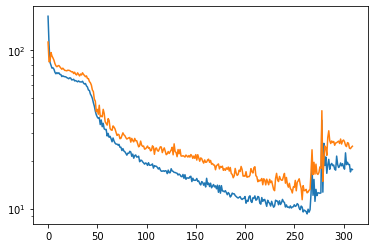

In [9]:
plt.plot(record_train_loss,label="valid")
plt.plot(record_valid_loss,label="train")
plt.yscale("log")